# What is recordclass

[Recordclass](https://pypi.python.org/pypi/recordclass) is a library for creation of `record`-like classes &ndash; "mutable" analog of [collections.namedtuple](https://docs.python.org/3/library/collections.html).
They support same API as namedtuples. In addition they also support assignment operations.

It can be installed via `pip` command:
```
pip install recordclass
```

In order to start import factory functions:

In [1]:
from recordclass import recordclass, structclass, make_dataclass, mutabletuple
import sys
print(sys.version)

3.9.2 (default, Feb 28 2021, 17:03:44) 
[GCC 10.2.1 20210110]


## Recordclass-based classes

`recordclass` is almost full analog of `collection.namedtuple`, but can be mutable. It is built upon `recordclass.mutabletuple` type as `collection.namedtuple` is built upon `tuple` type. `Mutabletuple`  is actually a mutable variant of `tuple`.

They are created by the same way as namedtuples:

In [2]:
R = recordclass("R", "a b c d e f g h")
r = R(*range(8))

Record has the same size as the equivalent namedtuple:

In [3]:
from sys import getsizeof as sizeof
from collections import namedtuple

R2 = namedtuple("R", "a b c d e f g h")
r2 = R2(*range(1,9))
print("recordclass: sizeof:", sizeof(r))
print("namedtuple:  sizeof:", sizeof(r2))

recordclass: sizeof: 88
namedtuple:  sizeof: 104


Record has the same text representation as namedtuple:

In [4]:
print(repr(r))
print(str(r))

R(a=0, b=1, c=2, d=3, e=4, f=5, g=6, h=7)
R(a=0, b=1, c=2, d=3, e=4, f=5, g=6, h=7)


It support access to field both by attribute and by index:

In [5]:
print('By index:', r.a, r.b, r.c, r.d, r.e, r.f, r.g, r.h)
print('By name: ', r[0], r[1], r[2], r[3], r[4], r[5], r[6], r[7])

By index: 0 1 2 3 4 5 6 7
By name:  0 1 2 3 4 5 6 7


Record can change the value of any it's field inplace:

In [6]:
r.a, r.b, r.c, r.d, r.e, r.f, r.g, r.h = r.a, 2*r.b, 3*r.c, 4*r.d, 5*r.e, 6*r.f, 7*r.g, 8*r.h
print(r)

r1 = r._replace(a=100, h=1000)
print(r1)
print('Are they same?', r1 is r)

R(a=0, b=2, c=6, d=12, e=20, f=30, g=42, h=56)
R(a=100, b=2, c=6, d=12, e=20, f=30, g=42, h=1000)
Are they same? True


Records supports iterative unpacking and iteration over values in fields:

In [7]:
a, b, c, d, e, f, g, h = r
print(a, b, c, d, e, f, g, h)

for v in r:
    print(v, end=" ")

100 2 6 12 20 30 42 1000
100 2 6 12 20 30 42 1000 

As namedtuple it can be converted to dict (infact to OrdeedDict as namedtuple):

In [8]:
r._asdict()

OrderedDict([('a', 100),
             ('b', 2),
             ('c', 6),
             ('d', 12),
             ('e', 20),
             ('f', 30),
             ('g', 42),
             ('h', 1000)])

Records are pickable and unpickable"

In [9]:
import pickle
r_pickled = pickle.dumps(r)
r_unpickled = pickle.loads(r_pickled)
r == r_unpickled

True

Recordclasses has `__attrs__` attribute and an empty `__slots__`:

In [10]:
print(R.__fields__)
print(R.__slots__)

('a', 'b', 'c', 'd', 'e', 'f', 'g', 'h')
()


Implementation of the recordclass is fast enough:

In [11]:
STest = namedtuple("TEST", "a b c d e f g h i j k")
nt = STest(a=1,b=2,c=3,d=4,e=5,f=6,g=7,h=8,i=9,j=10,k=11)

RTest = recordclass("RTEST", "a b c d e f g h i j k")
rc = RTest(a=1,b=2,c=3,d=4,e=5,f=6,g=7,h=8,i=9,j=10,k=11)

RTest2 = structclass("RTEST", "a b c d e f g h i j k")
sc = RTest2(a=1,b=2,c=3,d=4,e=5,f=6,g=7,h=8,i=9,j=10,k=11)

RTest3 = structclass("RTEST", "a b c d e f g h i j k", gc=True)
sc2 = RTest3(a=1,b=2,c=3,d=4,e=5,f=6,g=7,h=8,i=9,j=10,k=11)

class Test(object):
    __slots__ = ["a","b","c","d","e","f","g","h","i","j","k"]

    def __init__(self, a, b, c, d, e, f, g, h, i, j, k):
        self.a = a; self.b = b; self.c = c
        self.d = d; self.e = e; self.f = f
        self.g = g; self.h = h; self.i = i
        self.j = j; self.k = k

b = Test(1,2,3,4,5,6,7,8,9,10,11)

c = {'a':1, 'b':2, 'c':3, 'd':4, 'e':5, 'f':6, 'g':7, 'h':8, 'i':9, 'j':10, 'k':11}

d = (1,2,3,4,5,6,7,8,9,10,11)
md = mutabletuple(1,2,3,4,5,6,7,8,9,10,11)
e = [1,2,3,4,5,6,7,8,9,10,11]
f = (1,2,3,4,5,6,7,8,9,10,11)
g = [1,2,3,4,5,6,7,8,9,10,11]
key = 10

# ND_V = new_datatype("ND_V", varsize=True)
# ndv = ND_V(1,2,3,4,5,6,7,8,9,10,11)

DO = make_dataclass("DO", fields=("a","b","c","d","e","f","g","h","i","j","k"), sequence=True, fast_new=True)
do = DO(1,2,3,4,5,6,7,8,9,10,11)


In [12]:
from timeit import timeit
import matplotlib.pyplot as plt
import matplotlib as mpl
print(mpl.style.available)
mpl.style.use(['seaborn-poster', 'seaborn-ticks', 'seaborn-white'])

labels1 = {
    'nt_a' : 'namedtuple/attribute',
    'nt_i' : 'namedtuple/index',
    'rc_a' : 'recordclass/attribute',
    'rc_i' : 'recordclass/index',
    'rc2_a' : 'structclass/attribute',
    'rc2_i' : 'structclass/index',
#     'ndv_i' : 'nd_varsize/index',
    'nds_i' : 'dataobject/index',
    'nds_a' : 'dataobject/attribute',
#     'ndvs_i' : 'nd_slots_varsize/index',
    'cs' : 'class/slots',
    'dt' : 'dict/key',
    'tp' : 'tuple/index',
    'mt' : 'mutabletuple/index',
    'lt' : 'list/index',
    'for' : 'for overhead',
}

import gc

d1 = {}
gc.collect()
#gc.disable()
d1['nt_a'] = timeit("z = nt.a; z = nt.f; z = nt.k", "from __main__ import nt")
d1['nt_i'] = timeit("z = nt[0]; z = nt[5]; z = nt[10]", "from __main__ import nt")
d1['rc_a'] = timeit("z = rc.a; z = rc.f; z = rc.k", "from __main__ import rc")
d1['rc_i'] = timeit("z = rc[0]; z = rc[5]; z = rc[10]", "from __main__ import rc")
d1['rc2_a'] = timeit("z = sc.a; z = sc.f; z = sc.k", "from __main__ import sc")
d1['rc2_i'] = timeit("z = sc[0]; z = sc[5]; z = sc[10]", "from __main__ import sc")
d1['nds_a'] = timeit("z = do.a; z = do.f; z = do.k", "from __main__ import do")
d1['nds_i'] = timeit("z = do.a; z = do.f; z = do[10]", "from __main__ import do")
d1['cs'] = timeit("z = b.a; z = b.f; z = b.k", "from __main__ import b")
d1['dt'] = timeit("z = c['a']; z = c['f']; z = c['k']", "from __main__ import c")
d1['tp'] = timeit("z = d[0]; z = d[5]; z = d[10]", "from __main__ import d")
d1['mt'] = timeit("z = md[0]; z = md[5]; z = md[10]", "from __main__ import md")
d1['lt'] = timeit("z = e[0]; z = e[5]; z = e[10]", "from __main__ import e")
#gc.enable()


['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


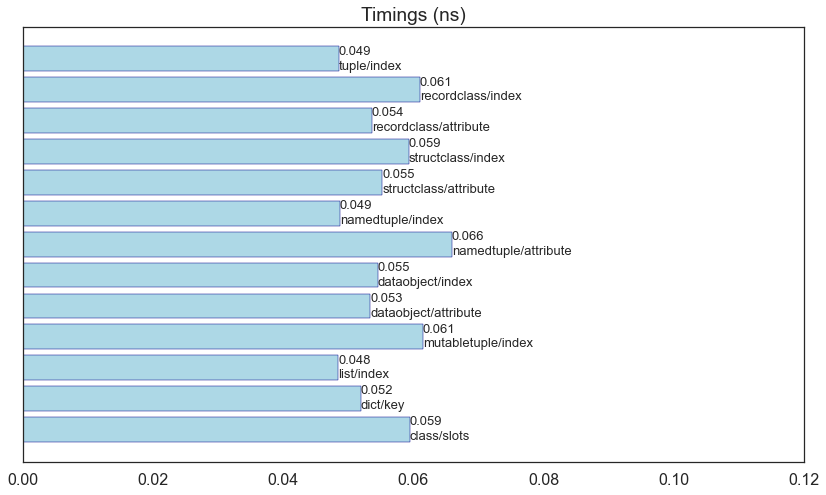

In [13]:
keys1 = list(sorted(d1.keys()))
n1 = len(d1)

plt.figure(figsize=(14,8))
plt.barh(range(n1), [d1[key] for key in keys1], color='LightBlue', edgecolor='DarkBlue')
for i,key in enumerate(keys1):
    plt.text(d1[key], i+0.15, '%.3f'%d1[key], fontdict={'size':13})
    plt.text(d1[key], i-0.33, labels1[key], fontdict={'size':13})
plt.yticks([],[])
plt.xlim(0,0.12)
plt.title('Timings (ns)')
plt.minorticks_on()
plt.savefig('recordclass_timings.png')
plt.show()

In [14]:
d2 = dict(
 nt = sizeof(nt),  
 rc = sizeof(rc),  
 sc = sizeof(sc),
#  ndv = sizeof(ndv),
 do = sizeof(do),
#  ndvs = sizeof(ndvs),
 cs = sizeof(b),
 tp = sizeof(d),
)

labels2 = dict(
    nt = 'namedtuple',
    rc = 'recordclass',
    sc = 'structclass',
#     ndv = 'nd_varsize',
    do = 'dataobject',
#     ndvs = 'nd_slots_varsize',
    cs = 'class/slots',
    tp = 'tuple',
)

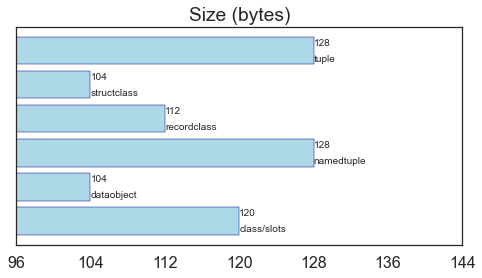

In [15]:
keys2 = list(sorted(d2.keys()))
n2 = len(d2)

plt.figure(figsize=(8,4))
plt.barh(range(n2), [d2[key] for key in keys2], color='LightBlue', edgecolor='DarkBlue')
for i,key in enumerate(keys2):
    plt.text(d2[key], i+0.15, '%d'%d2[key])
    plt.text(d2[key], i-0.33, labels2[key])
plt.yticks([],[])
plt.title('Size (bytes)')
plt.xlim(96,144)
plt.xticks([96,104,112,120,128,136,144])
plt.savefig('recordclass_memory.png')
plt.show()

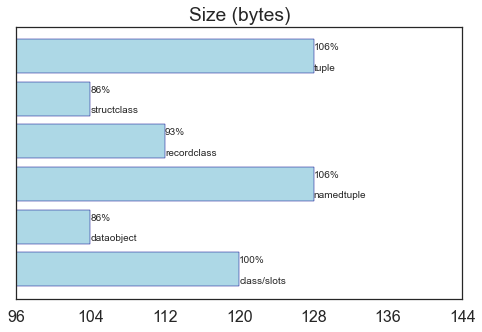

In [16]:
B = 120

plt.figure(figsize=(8,5))
plt.barh(range(n2), [d2[key] for key in keys2], color='LightBlue', edgecolor='DarkBlue')
for i,key in enumerate(keys2):
    v = (d2[key] / B) * 100
    plt.text(d2[key], i+0.15, '%d%%'% v)
    plt.text(d2[key], i-0.33, labels2[key])
plt.yticks([],[])
plt.title('Size (bytes)')
plt.xlim(96,144)
plt.xticks([96,104,112,120,128,136,144])
plt.show()

## Structclass

Infact recordclass instances require more memory than `__slots__`-based instances:

In [17]:
class R:
    __slots__ = ('a', 'b', 'c')
    def __init__(self, a, b, c):
        self.a = a
        self.b = b
        self.c = c
        
RC = recordclass('R', 'a b c')
r = R(1,2,3)
rc = RC(1,2,3)

print(sizeof(r), sizeof(rc))

56 48


This is because a tuple object and correspondently a recordclass-based instance contains its size when an `__slots__`-based instance is not.

As the solution the `structclass` factory function is invented. It created classes, whose instances are not contain the size (it's `PyObject`-kind object, not `PyObjectVar`-kind) and has same memory layout as `__slots__`-based ones. But they are not `__slots__`-based and doesn't support cyclic garbage collection by default (it's natural for nonrecursive records and simple structs).

In [18]:
RS = structclass('RS', 'a b c')
rs = RS(1,2,3)

print(sizeof(rs), sizeof(r), sizeof(rc))

40 56 48


It can be turn on cyclic garbage collection. Then it will have same size as `__slots__`-based one.

In [19]:
RS_gc = structclass('RS_gc', 'a b c', gc=True)
rs_gc = RS_gc(1,2,3)

print(sizeof(rs_gc), sizeof(r), sizeof(rc))

56 56 48


Here is the table for sizes comparisons:

In [20]:
import pandas as pd

df = pd.DataFrame(
    [(sizeof(rc), 
      sizeof(nt),
      sizeof(b),
      sizeof(sc),
      sizeof(sc2),
     )
    ], columns=[
        'recordclass', 'namedtuple', 'class+__slots__', 
        'structclass/no_gc', 'structclass/gc'], index=['size'])
df

,recordclass,namedtuple,class+__slots__,structclass/no_gc,structclass/gc
size,48,128,120,104,120


It can be also turn on `__dict__`:

In [21]:
RS_d = structclass('RS_d', 'a b c', use_dict=True)

rs_d = RS_d(1,2,3)
rs_d.d = 100
rs_d.e = 200
rs_d.f = 300
print(rs_d)
print(sizeof(rs_d), rs_d.__dict__)

RS_d(a=1, b=2, c=3, **{'d': 100, 'e': 200, 'f': 300})
48 {'d': 100, 'e': 200, 'f': 300}


In [22]:
rs_pickled = pickle.dumps(rs)
rs_unpickled = pickle.loads(rs_pickled)
print(rs == rs_unpickled)
rs_d_pickled = pickle.dumps(rs_d)
rs_d_unpickled = pickle.loads(rs_d_pickled)
print(rs_d == rs_d_unpickled)

True
True


## Type hints for python ≥3.6

In [23]:
from recordclass import RecordClass, StructClass

In [24]:
class RC(RecordClass):
    name: str
    age: int

class SC(StructClass):
    name: str
    age: int
        

In [25]:
rc = RC("John", 36)
sc = SC("John", 36)

In [26]:
print(rc.name, rc.age)
print(sc.name, sc.age)

John 36
John 36


In [27]:
print(RC.__annotations__)
print(SC.__annotations__)

{'name': <class 'str'>, 'age': <class 'int'>}
{'name': <class 'str'>, 'age': <class 'int'>}


In [28]:
A = structclass('A', 'a')

class B(A):
    pass


In [29]:
Point1 = recordclass('Point1', 'a b')
Point2 = structclass('Point3', 'a b', gc=True)
Point3 = structclass('Point2', 'a b')

lst1 = [Point1(i, i) for i in range(10000)]
lst2 = [Point2(i, i) for i in range(10000)]
lst3 = [Point3(i, i) for i in range(10000)]

def calculate_size(lst):
    size1 = sys.getsizeof(lst)
    size2 = sum(sys.getsizeof(ob) for ob in lst)
    size = size1 + size2
    return size

size1 = calculate_size(lst1)
size2 = calculate_size(lst2)
size3 = calculate_size(lst3)

print(size1, size2, size3)

print("100%")
print("%.0f%%" % (100*size2/size1))
print("%.0f%%" % (100*size3/size1))

485176 565176 405176
100%
116%
84%
